In [1]:
import pandas as pd

# Paths to the datasets
training_data_34_66_path = '/data/notebook_files/training_data_34_66.csv'
training_data_10_90_path = '/data/notebook_files/training_data_10_90.csv'
X_test_path = '/data/notebook_files/X_test.csv'
y_test_path = '/data/notebook_files/y_test.csv'

# Loading the datasets
training_data_34_66 = pd.read_csv(training_data_34_66_path)
training_data_10_90 = pd.read_csv(training_data_10_90_path)
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

# Autoencoder Computation on the 34:66 Class Distribution

In [2]:
X_train_34_66 = training_data_34_66.drop('Class', axis=1)
y_train_34_66 = training_data_34_66['Class']

y_test = y_test.squeeze() 

In [3]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 730.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
  

Epoch 1/100
1191/1191 [==============================] - 5s 3ms/step - loss: 0.4649 - accuracy: 0.9318 - val_loss: 0.2385 - val_accuracy: 0.9658
Epoch 2/100
1191/1191 [==============================] - 4s 3ms/step - loss: 0.2831 - accuracy: 0.9662 - val_loss: 0.1891 - val_accuracy: 0.9735
Epoch 3/100
1191/1191 [==============================] - 4s 3ms/step - loss: 0.2259 - accuracy: 0.9731 - val_loss: 0.1608 - val_accuracy: 0.9773
Epoch 4/100
1191/1191 [==============================] - 4s 3ms/step - loss: 0.1884 - accuracy: 0.9782 - val_loss: 0.1397 - val_accuracy: 0.9807
Epoch 5/100
1191/1191 [==============================] - 4s 3ms/step - loss: 0.1596 - accuracy: 0.9825 - val_loss: 0.1219 - val_accuracy: 0.9841
Epoch 6/100
1191/1191 [==============================] - 4s 3ms/step - loss: 0.1386 - accuracy: 0.9851 - val_loss: 0.1101 - val_accuracy: 0.9854
Epoch 7/100
1191/1191 [==============================] - 4s 3ms/step - loss: 0.1213 - accuracy: 0.9875 - val_loss: 0.0949 - val_ac

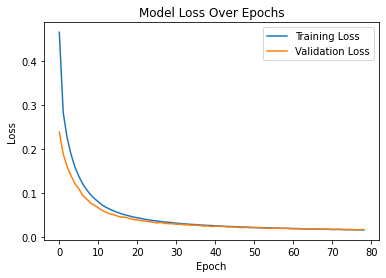

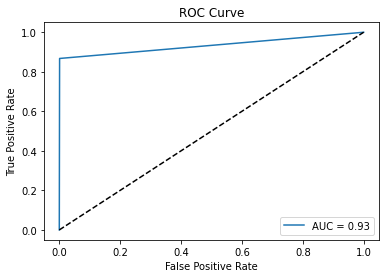

In [10]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Building the Neural Network
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(30,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Class weights
class_weights = {0: 1, 1: 5}

# Train the model
history = model.fit(
    X_train_34_66, y_train_34_66, 
    epochs=100, 
    batch_size=256, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping], 
    class_weight=class_weights
)

# Evaluate the model using the test data
predictions = model.predict(X_test)
predictions = predictions > 0.5  # Convert probabilities to binary predictions

# Calculate the confusion matrix and metrics
conf_mat = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = conf_mat.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f2_score = (5 * precision * recall) / (4 * precision + recall)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the confusion matrix and metrics
print('Confusion Matrix')
print(conf_mat)
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'F2 Score: {f2_score}')

# Autoencoding Computation on the 10:90 Class Distribution

In [12]:
X_train_10_90 = training_data_10_90.drop('Class', axis=1)
y_train_10_90 = training_data_10_90['Class']

y_test = y_test.squeeze() 

Epoch 1/100
978/978 [==============================] - 4s 3ms/step - loss: 0.4248 - accuracy: 0.9541 - val_loss: 0.1810 - val_accuracy: 0.9923
Epoch 2/100
978/978 [==============================] - 3s 3ms/step - loss: 0.2528 - accuracy: 0.9819 - val_loss: 0.1551 - val_accuracy: 0.9909
Epoch 3/100
978/978 [==============================] - 3s 3ms/step - loss: 0.2114 - accuracy: 0.9833 - val_loss: 0.1336 - val_accuracy: 0.9909
Epoch 4/100
978/978 [==============================] - 3s 3ms/step - loss: 0.1812 - accuracy: 0.9849 - val_loss: 0.1168 - val_accuracy: 0.9916
Epoch 5/100
978/978 [==============================] - 3s 3ms/step - loss: 0.1588 - accuracy: 0.9860 - val_loss: 0.1036 - val_accuracy: 0.9924
Epoch 6/100
978/978 [==============================] - 3s 3ms/step - loss: 0.1394 - accuracy: 0.9873 - val_loss: 0.0933 - val_accuracy: 0.9930
Epoch 7/100
978/978 [==============================] - 3s 3ms/step - loss: 0.1241 - accuracy: 0.9886 - val_loss: 0.0845 - val_accuracy: 0.9932

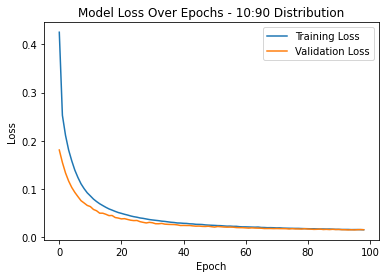

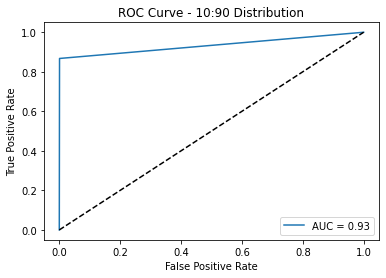

In [13]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Building the Neural Network
model_10_90 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(30,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_10_90.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

# Callback for early stopping
early_stopping_10_90 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Class weights
class_weights_10_90 = {0: 1, 1: 5}

# Train the model
history_10_90 = model_10_90.fit(
    X_train_10_90, y_train_10_90, 
    epochs=100, 
    batch_size=256, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping_10_90], 
    class_weight=class_weights_10_90
)

# Evaluate the model using the test data
predictions_10_90 = model_10_90.predict(X_test)
predictions_10_90 = predictions_10_90 > 0.5  # Convert probabilities to binary predictions

# Calculate the confusion matrix and metrics
conf_mat_10_90 = confusion_matrix(y_test, predictions_10_90)
tn_10_90, fp_10_90, fn_10_90, tp_10_90 = conf_mat_10_90.ravel()
recall_10_90 = tp_10_90 / (tp_10_90 + fn_10_90)
precision_10_90 = tp_10_90 / (tp_10_90 + fp_10_90)
accuracy_10_90 = (tp_10_90 + tn_10_90) / (tp_10_90 + tn_10_90 + fp_10_90 + fn_10_90)
f2_score_10_90 = (5 * precision_10_90 * recall_10_90) / (4 * precision_10_90 + recall_10_90)

# Plot training and validation loss
plt.plot(history_10_90.history['loss'], label='Training Loss')
plt.plot(history_10_90.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs - 10:90 Distribution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# ROC Curve and AUC
fpr_10_90, tpr_10_90, thresholds_10_90 = roc_curve(y_test, predictions_10_90)
roc_auc_10_90 = roc_auc_score(y_test, predictions_10_90)
plt.plot(fpr_10_90, tpr_10_90, label=f'AUC = {roc_auc_10_90:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 10:90 Distribution')
plt.legend(loc='lower right')
plt.show()

# Print the confusion matrix and metrics
print('Confusion Matrix')
print(conf_mat_10_90)
print(f'TN: {tn_10_90}, FP: {fp_10_90}, FN: {fn_10_90}, TP: {tp_10_90}')
print(f'Recall: {recall_10_90}')
print(f'Precision: {precision_10_90}')
print(f'Accuracy: {accuracy_10_90}')
print(f'F2 Score: {f2_score_10_90}')